In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
import statsmodels.formula.api as smf
from pandas import read_csv
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression



%matplotlib inline

train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/item_categories.csv')

def preprocess_date(data):
    data['date'], data['month'], data['year'] = data['date'].str.split('.').str
    data[['date']] = data[['date']].astype(int)
    data[['month']] = data[['month']].astype(int)
    data[['year']] = data[['year']].astype(int)
    return data

print(preprocess_date(train).head())




   date  date_block_num  shop_id  item_id  item_price  item_cnt_day  month  \
0     2               0       59    22154      999.00           1.0      1   
1     3               0       25     2552      899.00           1.0      1   
2     5               0       25     2552      899.00          -1.0      1   
3     6               0       25     2554     1709.05           1.0      1   
4    15               0       25     2555     1099.00           1.0      1   

   year  
0  2013  
1  2013  
2  2013  
3  2013  
4  2013  


In [2]:
from collections import Counter

def groupby_dbn_shopid_item(data):
    month_sales = data.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
    return month_sales

def get_monthlysales_by_itemid(data, itemid):
    select_by_item = data[data["item_id"]==itemid]
    monthlysales_group = select_by_item.groupby(["date_block_num"])
    result = (monthlysales_group[["item_cnt_day"]].sum().reset_index())
    result = result.rename(columns={ "item_cnt_day": "item_cnt_month" })
    return result


data = train
print(train.head())
c = Counter(data["item_id"])

monthlysales = get_monthlysales_by_itemid(data, 5527)

print(monthlysales)


   date  date_block_num  shop_id  item_id  item_price  item_cnt_day  month  \
0     2               0       59    22154      999.00           1.0      1   
1     3               0       25     2552      899.00           1.0      1   
2     5               0       25     2552      899.00          -1.0      1   
3     6               0       25     2554     1709.05           1.0      1   
4    15               0       25     2555     1099.00           1.0      1   

   year  
0  2013  
1  2013  
2  2013  
3  2013  
4  2013  
    date_block_num  item_cnt_month
0                0             3.0
1                1             2.0
2                2             1.0
3                3             4.0
4                4             2.0
5                5             2.0
6                6             4.0
7                7             4.0
8                8             2.0
9                9             1.0
10              10             5.0
11              11             1.0
12              

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3027      0.305      0.994      0.320      -0.294       0.900
ma.L1         -0.9763      0.321     -3.042      0.002      -1.605      -0.347
ma.L2         -0.1787      0.390     -0.458      0.647      -0.944       0.586
ar.S.L12      -0.1044      0.149     -0.702      0.482      -0.396       0.187
sigma2      4.127e+06   9.79e-08   4.22e+13      0.000    4.13e+06    4.13e+06


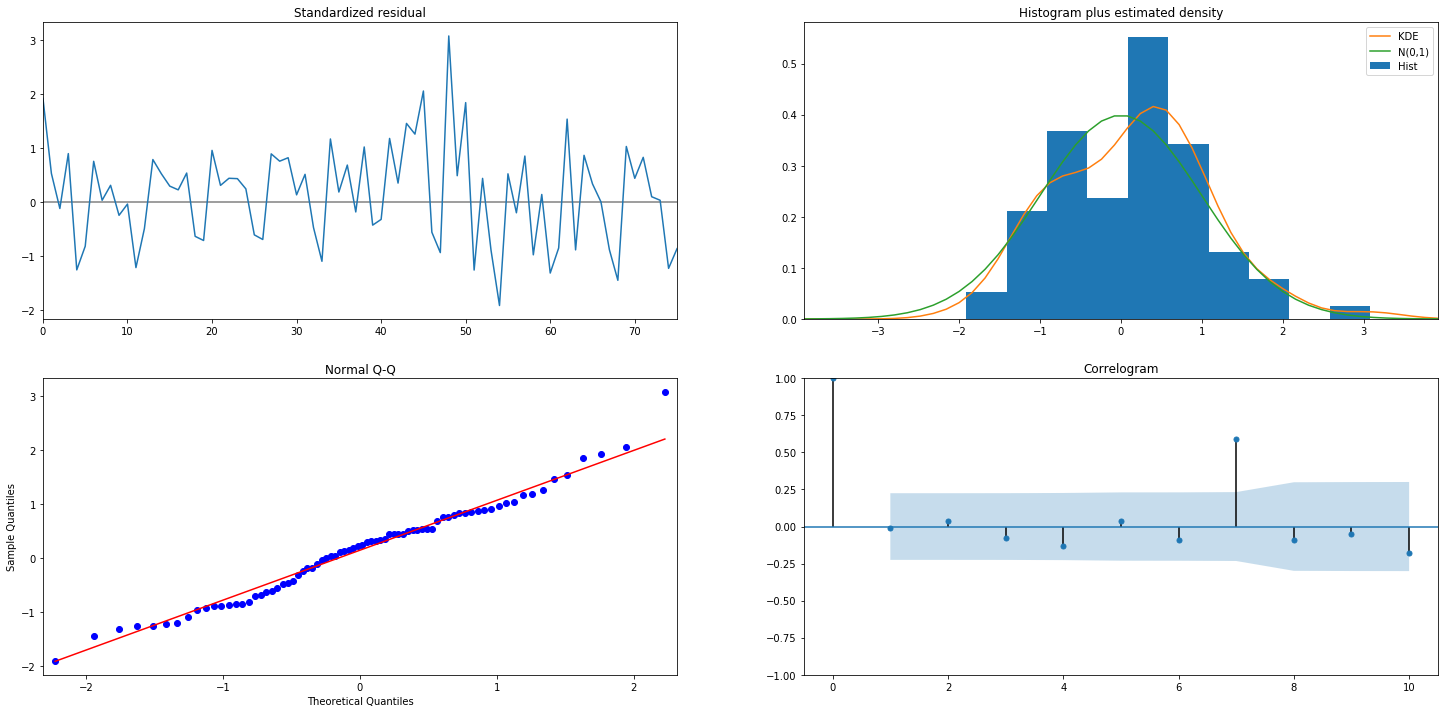

[11738.64236088]


array([11738.64236088])

In [15]:
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



def arima_predict(data, param_order=(1,1,2), plot_diag=True, param_seasonal_order=(1,0,0,12)):
    '''
    data = pd.DataFrame(data)
    acf = plot_acf(data,lags=20)
    pacf = plot_pacf(data,lags=20)
    for i in range(3):
        data_diff = data.diff(1)
        diff = data.dropna()
    plt.figure()
    plt.plot(diff)
    '''
    
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=param_order,
                                    seasonal_order=param_seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                   )
    results = mod.fit()
    if plot_diag:
        print(results.summary().tables[1])
        results.plot_diagnostics(figsize=(25, 12))
        plt.show()
    
    pred = results.get_prediction(10, dynamic=False)
    pred_ci = pred.conf_int()
    #print(pred_ci)
    #print(pred_ci.shape)
    predict_answer = results.forecast(1)
    print((results.forecast(1)))
    return predict_answer

dta=[10930,10318,10595,10972,7706,6756,9092,10551,9722,10913,11151,8186,6422,
6337,11649,11652,10310,12043,7937,6476,9662,9570,9981,9331,9449,6773,6304,9355,
10477,10148,10395,11261,8713,7299,10424,10795,11069,11602,11427,9095,7707,10767,
12136,12812,12006,12528,10329,7818,11719,11683,12603,11495,13670,11337,10232,
13261,13230,15535,16837,19598,14823,11622,19391,18177,19994,14723,15694,13248,
9543,12872,13101,15053,12619,13749,10228,9725,14729,12518,14564,15085,14722,
11999,9390,13481,14795,15845,15271,14686,11054,10395]

arima_predict(dta)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4791      7.576     -0.063      0.950     -15.328      14.370
ma.L1          0.4769      7.502      0.064      0.949     -14.226      15.180
ma.L2          0.0505      1.411      0.036      0.971      -2.715       2.816
ar.S.L12       0.7545      0.589      1.282      0.200      -0.399       1.908
sigma2      5.273e+08   4.73e-09   1.12e+17      0.000    5.27e+08    5.27e+08


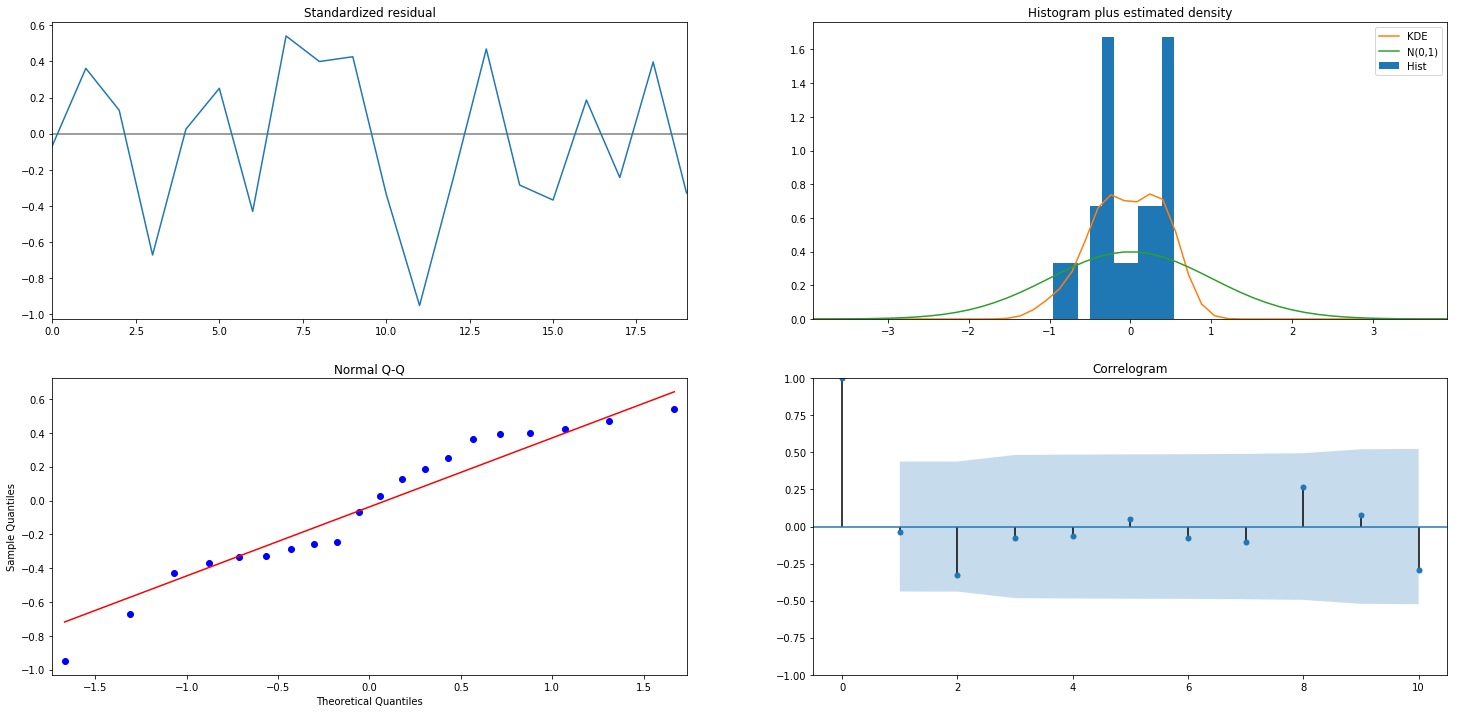

34    79610.656954
dtype: float64


34    79610.656954
dtype: float64

In [9]:
def get_series_data(data, feature_name): #DataFram, string
    monthlydata_group = data.groupby(["date_block_num"])
    monthlydata = (monthlydata_group[[feature_name]].sum().reset_index())
    monthlydata = monthlydata.rename(columns={feature_name:feature_name+'_group'})
    #fill date_block_num
    listdata = [i for i in range(34)]
    new_data = pd.DataFrame(listdata, columns=['date_block_num'])
    new_data = pd.merge(new_data, monthlydata, how='outer')
    result = new_data.fillna(0)
    return result

def get_series_data_average(data, feature_name): #DataFram, string
    monthlydata_group = data.groupby(["date_block_num"])
    monthlydata = (monthlydata_group[[feature_name]].mean().reset_index())
    monthlydata = monthlydata.rename(columns={feature_name:feature_name+'_group'})
    #fill date_block_num
    listdata = [i for i in range(34)]
    new_data = pd.DataFrame(listdata, columns=['date_block_num'])
    new_data = pd.merge(new_data, monthlydata, how='outer')
    result = new_data.fillna(method="ffill").fillna(method="bfill")
    return result

total_monthlysales= get_series_data(data, "item_cnt_day")
arima_predict(total_monthlysales['item_cnt_day_group'])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5321      2.006     -0.265      0.791      -4.464       3.400
ar.S.L12       0.6788      0.501      1.356      0.175      -0.302       1.660
sigma2      2.493e+09   8.53e-11   2.92e+19      0.000    2.49e+09    2.49e+09


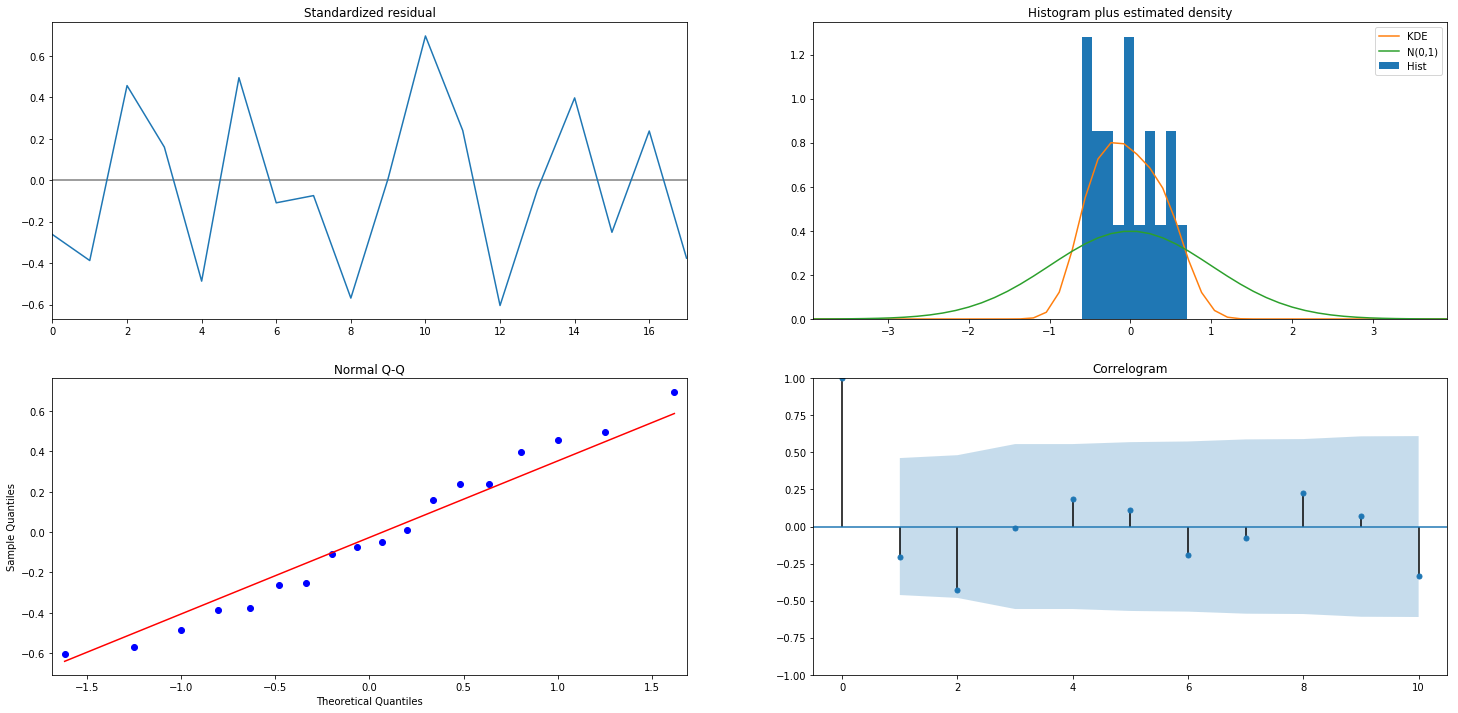

34    70503.917966
dtype: float64


34    70503.917966
dtype: float64

In [25]:
arima_predict(total_monthlysales['item_cnt_day_group'],(1,3,0),(1,0,0,12))

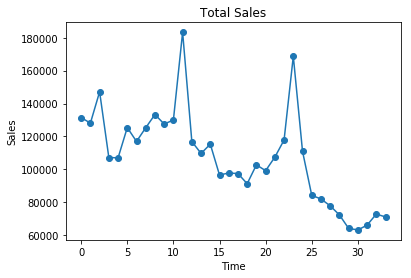

In [6]:
plt.title("Total Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(total_monthlysales['item_cnt_day_group'],marker='o')


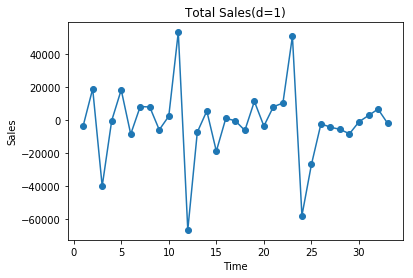

In [7]:
item_cnt_day_group_diff = total_monthlysales['item_cnt_day_group'].diff(periods=1)
item_cnt_day_group_diff
plt.title("Total Sales(d=1)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(item_cnt_day_group_diff, marker='o')


In [24]:
#arima predict

#item price predict
testdata = get_series_data_average(data[data.item_id==1], "item_price")
testdata['item_price_group']
print([2]*10)
#arima_predict([4490]*50,plot_diag=False)
#data[data.item_id==1]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


$$
\mathrm{y}_{\mathrm{t}}=\delta+\phi_{1} \mathrm{y}_{\mathrm{t}-1}+\phi_{2} \mathrm{y}_{\mathrm{t}-2}+\ldots+\phi_{\mathrm{p}} \mathrm{y}_{\mathrm{t}-1}+\mathrm{A}_{\mathrm{t}}
$$
$$ \delta=\left(1-\sum_{i=1}^{p} \phi_{i}\right) \mu $$

# PPT NOTE

# ARIMA model
- do not need other features
- stationary



## AR(p) Models
The value for “p” is the order.  
 - AR(1) would be a “first order autoregressive process.” 

A second or third order AR process would be related to data two or three periods apart.

$$\mathrm{y}_{\mathrm{t}}=\delta+\phi_{1} \mathrm{y}_{\mathrm{t}-1}+\phi_{2} \mathrm{y}_{\mathrm{t}-2}+\ldots+\phi_{\mathrm{p}} \mathrm{y}_{\mathrm{t}-1}+\mathrm{A}_{\mathrm{t}}$$

- yt-1, yt-2…yt-p are the past series values (lags),
- At is white noise (i.e. randomness), 
- and δ is defined by the following equation

$$\delta=\left(1-\sum_{i=1}^{p} \phi_{i}\right) \mu$$

μ is the mean


## MA(q) Models
The 1st order moving average model, denoted by MA(1) is
$$x_{t}=\mu+w_{t}+\theta_{1} w_{t-1}$$

The qth order moving average model, denoted by MA(q) is
$$
x_{t}=\mu+w_{t}+\theta_{1} w_{t-1}+\theta_{2} w_{t-2}+\cdots+\theta_{q} w_{t-q}
$$

## ARIMA Models
add a parameter d representing the order of integration (the I in ARIMA)

differencing
d=1
$$
\Delta y_{x}=y_{x+1}-y_{x}
$$

d=2
$$
\Delta^{2} y_{x}=y_{x+2}-2 y_{x+1}+y_{x}
$$

d=n
$$
\Delta^{n} y_{x}=\Delta\left(\Delta^{n-1} y_{x}\right)=\Delta^{n-1} y_{x+1}-\Delta^{n-1} y_{x}
$$

## Seasonal ARIMA
- are usually denoted SARIMA(p,d,q)(P,D,Q)m
- m refers to the number of periods in each season
- P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model

# Apply to the data

arima-total-sales-month.png

differencing

arima-total-sales-month-diff

In [ ]:
plt.title("Total Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(total_monthlysales['item_cnt_day_group'],marker='o')

In [ ]:
item_cnt_day_group_diff = total_monthlysales['item_cnt_day_group'].diff(periods=1)
item_cnt_day_group_diff
plt.title("Total Sales(d=1)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(item_cnt_day_group_diff, marker='o')


In [ ]:
arima_predict(total_monthlysales['item_cnt_day_group'],(1,3,0),(1,0,0,12))

# SARIMA in python

mod = sm.tsa.statespace.SARIMAX(data,
                                order=param_order,
                                seasonal_order=param_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    results.summary().tables[1]
    results.forecast(1)
    
    